In [11]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import IPython
import seaborn as sns
import pylab as pl
from tqdm import tqdm

In [20]:
class VacuumCleaner():
    def __init__(self, size=5, sym_empty='░░ ', sym_trash='▓▓ ',
                 sym_vacuum='〄 '):
        
        self.size = size
        self.sym_empty = sym_empty
        self.sym_trash = sym_trash
        self.sym_vacuum = sym_vacuum
        
        
        self.matrix_trash = np.zeros((self.size, self.size))
        self.matrix_vacuum = np.zeros((self.size, self.size))
        
        
        
        self.string_mapping = np.vectorize(lambda s: self.sym_empty if s == 0
                                    else self.sym_trash if s == 1
                                    else self.sym_vacuum)
        self.field = np.zeros((self.size, self.size))
        
        
        self.v_path = np.zeros((self.size, self.size))
        self.v_path[1:(self.size - 1), 1] = np.ones((self.size - 2))
        self.v_path[1:(self.size - 1), (self.size - 2)] = np.ones((self.size - 2))
        self.v_path[1, 1:(self.size - 1)] = np.ones((self.size - 2))
        self.v_path[(self.size - 2), 1:(self.size - 1)] = np.ones((self.size - 2))
        self.v_path_indexes = np.array(np.where(self.v_path == 1)).transpose()
        
        
        self.v_path3 = np.zeros((self.size, self.size))
        self.v_path3[0, 0] = 1
        self.v_path3[0, (self.size - 1)] = 1
        self.v_path3[(self.size - 1),0] = 1
        self.v_path3[(self.size - 1), (self.size - 1)] = 1
        self.v_path3_indexes = np.array(np.where(self.v_path3 == 1)).transpose()
        
        self.directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        
        self.speed = 0.1
        self.style = 'stat'
        
    def output_iteration(self, i):
        if (i%999==0) & (self.style!='print'):
            IPython.display.clear_output(wait=True)
            print('Крок {:>4d} '.format(i + 1))
            self.calculate_trash()
            print('Кількість сміття на полі: {:.1f}'.format(self.trash))
            if self.style=='print':
                self.print_field()
            time.sleep(self.speed)
        if(self.style=='print'):
            IPython.display.clear_output(wait=True)
            print('Крок {:>4d} '.format(i + 1))
            self.calculate_trash()
            print('Кількість сміття на полі: {:.1f} одиниць'.format(self.trash))
            if self.style=='print':
                self.print_field()
            time.sleep(self.speed)
        self.calculate_trash()
        return self.trash
    
    def print_field(self):
        print('\n'.join(''.join(str(cell) for cell in row) for row in self.string_mapping(self.field)))
    
    def calculate_trash(self):
        self.trash = (self.field == 1).sum()
    
                    
    def check_near_trash(self):
        np.random.shuffle(self.directions)
        
        self.stepped = False
        min_distance = self.size * self.size
        
        # defining cells with trash
        self.trash_around = []
        for direction in self.directions:
            possible_v_pos = tuple(np.array(self.v_pos) + np.array(direction))
            if possible_v_pos[0] in range(self.size) and possible_v_pos[1] in range(self.size) and self.field[possible_v_pos] == 1:
                self.trash_around.append(possible_v_pos) 
        
        # step to the "best" trashy cell
        if len(self.trash_around)!=0:
            for possible_v_pos in self.trash_around: 
                if np.sort(np.linalg.norm(abs(self.v_path3_indexes - possible_v_pos), axis = 1))[0] < min_distance:
                    min_distance = np.sort(np.linalg.norm(abs(self.v_path3_indexes - possible_v_pos), axis = 1))[0]
                    self.best_v_pos = possible_v_pos
            self.prev = self.v_pos #remember previos state
            self.field[self.v_pos] = 0
            self.field[self.best_v_pos] = 2
            self.v_pos = self.best_v_pos
            self.stepped =  True
            
        # If there is not trash around
        min_distance = self.size * self.size
        if not self.stepped:
            for direction in self.directions:
                possible_v_pos = tuple(np.array(self.v_pos) + np.array(direction)) 
                if possible_v_pos==self.prev:
                    continue
                if np.sort(np.linalg.norm(abs(self.v_path_indexes - possible_v_pos), axis = 1))[0] < min_distance:
                    min_distance = np.sort(np.linalg.norm(abs(self.v_path_indexes - possible_v_pos), axis = 1))[0]
                    self.best_v_pos = possible_v_pos

        
        
                
    def is_vacuum_on_his_path(self):
        return((self.v_path * self.field == 2).any())
    
    def run_process(self, iterations=100, speed=0.1,
                    path_type='right', style='stat'):
        self.iterations = iterations
        self.path_type = path_type
        self.speed = speed
        self.style = style

        self.v_pos = (0, 0)
        self.field[self.v_pos] = 2
        res=0 
        self.prev = self.v_pos
        for i in range(self.iterations):
            self.free_field_indexes = np.array(np.where(self.field == 0)).transpose()
            index_to_fill = random.choice(self.free_field_indexes)
            if np.random.rand() > 0.5:
                self.field[index_to_fill[0],index_to_fill[1]] = 1
                self.matrix_trash[index_to_fill[0],index_to_fill[1]]+=1
            
            # output
            self.output_iteration(i)
            
            # check trash
            # move and clear if trash is near with little trick
            self.check_near_trash()
            
            # move to/along vacuum path if there isn't any trash
            if not self.stepped:
                self.prev = self.v_pos #remember previos state
                self.field[self.v_pos] = 0
                self.field[self.best_v_pos] = 2
                self.matrix_vacuum[self.best_v_pos]+=1
                self.v_pos = self.best_v_pos 
            
            # output
            res = self.output_iteration(i)
        return res

# Observation tests

In [21]:
v = VacuumCleaner(5)
v.run_process(iterations=100, speed=0.07, path_type='1', style='print')
#pl.clf()

Крок  100 
Кількість сміття на полі: 4.0 одиниць
▓▓ ░░ ░░ ░░ ░░ 
░░ ░░ ░░ ▓▓ ░░ 
░░ ░░ ░░ ▓▓ ░░ 
░░ ░░ ░░ ░░ ░░ 
▓▓ ░░ 〄 ░░ ░░ 


4

In [22]:
import numpy as np; np.random.seed(0)
import seaborn as sns; 
sns.set()

Крок    1 
Кількість сміття на полі: 0.0
4.785


Text(0.5,1,'Trash distribution')

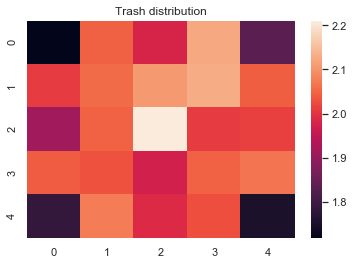

In [23]:
trash = []
vacuum = []
avg_res = []

# running 1000 times the vacuum algorithm
for i in range(1000):
    v = VacuumCleaner(5)
    avg_res.append(v.run_process(iterations=100, speed=0, path_type='1'))
    trash.append(v.matrix_trash)
    vacuum.append(v.matrix_vacuum)

# for analytics
mean_trash = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        mean_trash[i,j] = np.mean([hh[i,j] for hh in trash])
        
mean_vacuum = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        mean_vacuum[i,j] = np.mean([hh[i,j] for hh in vacuum])

print(np.mean(avg_res))
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
ax = sns.heatmap(mean_trash)
plt.title('Trash distribution')

Text(0.5,1,'vacuum distribution')

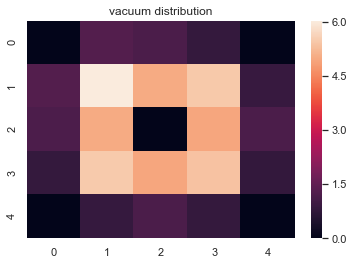

In [24]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
ax = sns.heatmap(mean_vacuum)
plt.title('vacuum distribution')

# Algorithm withouresult
### Average number of trash is approx. 4.78